# Week 15, Day 1: Attention Mechanisms for Financial Time Series

## Learning Objectives
1. Understand the intuition behind attention mechanisms
2. Master Query, Key, Value (Q, K, V) concepts
3. Implement scaled dot-product attention from scratch
4. Visualize attention weights for interpretability
5. Apply simple attention to financial time series

---

## 1. The Attention Revolution

### From RNNs to Attention

**Problem with RNNs/LSTMs:**
- Sequential processing → slow, can't parallelize
- Information bottleneck through fixed-size hidden state
- Difficulty attending to specific past time steps

**Attention Solution:**
- Direct connections to all positions in sequence
- Dynamic weighting based on relevance
- Interpretable: see which inputs the model "pays attention to"

### Intuition: "Looking Up" Relevant Information

Think of attention as a **soft dictionary lookup**:

```
Traditional Dictionary:    Attention Mechanism:
┌─────────────────┐        ┌─────────────────────────┐
│ Key → Value     │        │ Query ~ Key₁ → α₁·Value₁│
│ "AAPL" → $150   │   vs   │ Query ~ Key₂ → α₂·Value₂│
│ "GOOGL" → $2800 │        │ Query ~ Key₃ → α₃·Value₃│
└─────────────────┘        │ Output = Σ αᵢ·Valueᵢ    │
  Exact match              └─────────────────────────┘
                             Weighted combination
```

**Trading Analogy:**
- **Query**: "What past market conditions are relevant to predict tomorrow's price?"
- **Keys**: Encoded representations of each historical day
- **Values**: Information to extract from each day
- **Attention weights**: How much to weight each historical day

## 2. Query, Key, Value (Q, K, V) Framework

### Mathematical Foundation

Given an input sequence $X \in \mathbb{R}^{n \times d}$ (n positions, d dimensions):

**Linear Projections:**
$$Q = XW^Q \quad \text{(Queries)}$$
$$K = XW^K \quad \text{(Keys)}$$
$$V = XW^V \quad \text{(Values)}$$

Where:
- $W^Q, W^K \in \mathbb{R}^{d \times d_k}$ — projection matrices for queries and keys
- $W^V \in \mathbb{R}^{d \times d_v}$ — projection matrix for values

### Understanding Q, K, V

| Component | Role | Trading Interpretation |
|-----------|------|------------------------|
| **Query (Q)** | "What am I looking for?" | Current market state asking about past |
| **Key (K)** | "What do I contain?" | Encoded summary of each historical point |
| **Value (V)** | "What information can I provide?" | Actual data to aggregate |

### Self-Attention

When Q, K, V all come from the **same** input sequence, we call it **self-attention**:
- Each position can attend to every other position
- Captures dependencies regardless of distance
- Foundation of Transformer architecture

## 3. Scaled Dot-Product Attention

### The Core Formula

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

**Step-by-step:**

1. **Compute similarity scores:**
   $$S = QK^T \in \mathbb{R}^{n \times n}$$
   
2. **Scale by $\sqrt{d_k}$:**
   $$S_{\text{scaled}} = \frac{S}{\sqrt{d_k}}$$
   
3. **Apply softmax (row-wise):**
   $$\alpha = \text{softmax}(S_{\text{scaled}}) \in \mathbb{R}^{n \times n}$$
   
4. **Weighted sum of values:**
   $$\text{Output} = \alpha V \in \mathbb{R}^{n \times d_v}$$

### Why Scale by $\sqrt{d_k}$?

Without scaling, for large $d_k$:
- Dot products can have large magnitude
- Softmax outputs become nearly one-hot (saturated)
- Gradients vanish → training fails

If $q, k \sim \mathcal{N}(0, 1)$, then $q \cdot k \sim \mathcal{N}(0, d_k)$

Dividing by $\sqrt{d_k}$ normalizes variance to 1.

```
Without Scaling:              With Scaling:
┌─────────────────┐          ┌─────────────────┐
│ softmax([100,   │          │ softmax([5,     │
│          1,     │   →      │          0.05,  │
│          0.5])  │          │          0.025])│
│                 │          │                 │
│ = [1, 0, 0]     │          │ = [0.9, 0.07,   │
│   (saturated!)  │          │        0.03]   │
└─────────────────┘          └─────────────────┘
```

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.1


## 4. Implementing Scaled Dot-Product Attention from Scratch

In [2]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Scaled Dot-Product Attention
    
    Args:
        query: (batch_size, seq_len, d_k)
        key: (batch_size, seq_len, d_k)
        value: (batch_size, seq_len, d_v)
        mask: Optional mask for causal attention
    
    Returns:
        output: (batch_size, seq_len, d_v)
        attention_weights: (batch_size, seq_len, seq_len)
    """
    d_k = query.size(-1)
    
    # Step 1: Compute attention scores
    # (batch, seq_len, d_k) @ (batch, d_k, seq_len) -> (batch, seq_len, seq_len)
    scores = torch.matmul(query, key.transpose(-2, -1))
    
    # Step 2: Scale by sqrt(d_k)
    scores = scores / np.sqrt(d_k)
    
    # Step 3: Apply mask (optional) - for causal/autoregressive attention
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # Step 4: Softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Step 5: Weighted sum of values
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights


# Demonstrate with simple example
print("=" * 60)
print("Scaled Dot-Product Attention Demo")
print("=" * 60)

# Create sample input: batch_size=1, seq_len=4, d_model=8
batch_size, seq_len, d_model = 1, 4, 8
x = torch.randn(batch_size, seq_len, d_model)

# For self-attention, Q=K=V are derived from same input
# In practice, we'd use linear projections
d_k = d_v = 8
W_q = nn.Linear(d_model, d_k, bias=False)
W_k = nn.Linear(d_model, d_k, bias=False)
W_v = nn.Linear(d_model, d_v, bias=False)

Q = W_q(x)  # Queries
K = W_k(x)  # Keys
V = W_v(x)  # Values

print(f"\nInput shape: {x.shape}")
print(f"Query shape: {Q.shape}")
print(f"Key shape: {K.shape}")
print(f"Value shape: {V.shape}")

# Apply attention
output, attn_weights = scaled_dot_product_attention(Q, K, V)

print(f"\nOutput shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"\nAttention weights (each row sums to 1):")
print(attn_weights.squeeze().detach().numpy().round(3))
print(f"\nRow sums: {attn_weights.squeeze().sum(dim=-1).detach().numpy()}")

Scaled Dot-Product Attention Demo

Input shape: torch.Size([1, 4, 8])
Query shape: torch.Size([1, 4, 8])
Key shape: torch.Size([1, 4, 8])
Value shape: torch.Size([1, 4, 8])

Output shape: torch.Size([1, 4, 8])
Attention weights shape: torch.Size([1, 4, 4])

Attention weights (each row sums to 1):
[[0.333 0.217 0.185 0.265]
 [0.196 0.257 0.231 0.316]
 [0.356 0.255 0.257 0.132]
 [0.172 0.268 0.367 0.193]]

Row sums: [1.        0.9999999 1.        1.       ]


## 5. Causal (Masked) Attention for Time Series

### Why Masking?

For time series prediction, we can only look at **past** data:
- Position $t$ can attend to positions $1, 2, ..., t$
- Cannot attend to future positions $t+1, t+2, ...$

### The Causal Mask

```
Attention Matrix (4 time steps):     Masked Attention:
         t=1  t=2  t=3  t=4                t=1  t=2  t=3  t=4
    ┌─────────────────────┐           ┌─────────────────────┐
t=1 │ α₁₁  α₁₂  α₁₃  α₁₄ │      t=1 │ α₁₁  -∞   -∞   -∞  │
t=2 │ α₂₁  α₂₂  α₂₃  α₂₄ │  →   t=2 │ α₂₁  α₂₂  -∞   -∞  │
t=3 │ α₃₁  α₃₂  α₃₃  α₃₄ │      t=3 │ α₃₁  α₃₂  α₃₃  -∞  │
t=4 │ α₄₁  α₄₂  α₄₃  α₄₄ │      t=4 │ α₄₁  α₄₂  α₄₃  α₄₄ │
    └─────────────────────┘           └─────────────────────┘
     (sees future!)                    (causal - no leakage)
```

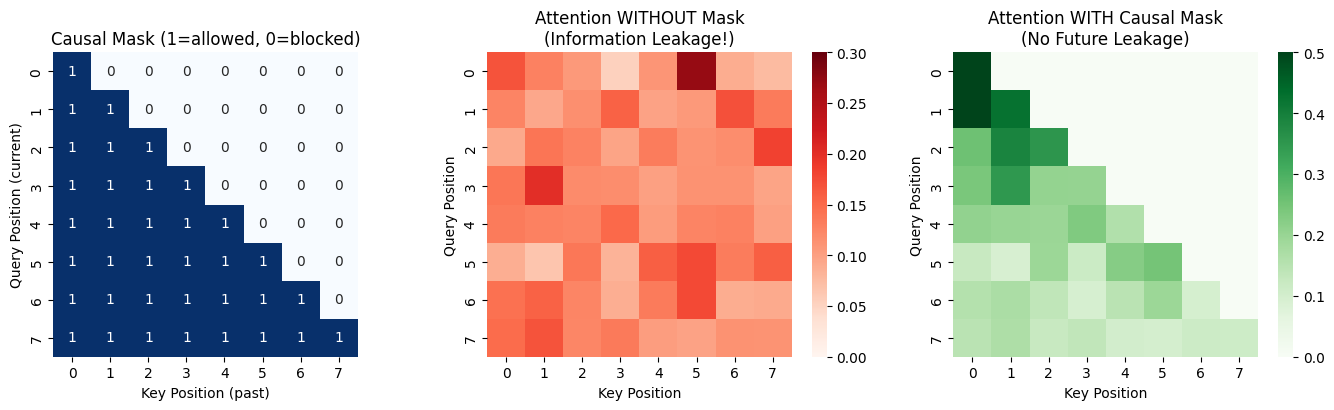


✅ With causal mask: Each row only has non-zero values for past/current positions
❌ Without mask: Model can 'cheat' by looking at future data!


In [3]:
def create_causal_mask(seq_len):
    """
    Create lower triangular mask for causal attention.
    Future positions are masked with 0 (will become -inf after masking).
    """
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask


# Create and visualize causal mask
seq_len = 8
causal_mask = create_causal_mask(seq_len)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Plot 1: Causal mask
sns.heatmap(causal_mask.numpy(), annot=True, fmt='.0f', cmap='Blues', 
            cbar=False, ax=axes[0], square=True)
axes[0].set_title('Causal Mask (1=allowed, 0=blocked)', fontsize=12)
axes[0].set_xlabel('Key Position (past)')
axes[0].set_ylabel('Query Position (current)')

# Create sample attention without mask
x_sample = torch.randn(1, seq_len, 16)
W_q_sample = nn.Linear(16, 16, bias=False)
W_k_sample = nn.Linear(16, 16, bias=False)
W_v_sample = nn.Linear(16, 16, bias=False)

Q_s = W_q_sample(x_sample)
K_s = W_k_sample(x_sample)
V_s = W_v_sample(x_sample)

# Plot 2: Attention without mask (BAD for prediction!)
_, attn_no_mask = scaled_dot_product_attention(Q_s, K_s, V_s, mask=None)
sns.heatmap(attn_no_mask.squeeze().detach().numpy(), cmap='Reds', 
            ax=axes[1], square=True, vmin=0, vmax=0.3)
axes[1].set_title('Attention WITHOUT Mask\n(Information Leakage!)', fontsize=12)
axes[1].set_xlabel('Key Position')
axes[1].set_ylabel('Query Position')

# Plot 3: Attention with causal mask (GOOD)
_, attn_with_mask = scaled_dot_product_attention(Q_s, K_s, V_s, mask=causal_mask)
sns.heatmap(attn_with_mask.squeeze().detach().numpy(), cmap='Greens', 
            ax=axes[2], square=True, vmin=0, vmax=0.5)
axes[2].set_title('Attention WITH Causal Mask\n(No Future Leakage)', fontsize=12)
axes[2].set_xlabel('Key Position')
axes[2].set_ylabel('Query Position')

plt.tight_layout()
plt.show()

print("\n✅ With causal mask: Each row only has non-zero values for past/current positions")
print("❌ Without mask: Model can 'cheat' by looking at future data!")

## 6. Load and Prepare Financial Data

In [4]:
# Download financial data
print("Downloading stock data...")
ticker = "AAPL"
df = yf.download(ticker, start="2018-01-01", end="2024-01-01", progress=False)

# Use Close price
prices = df['Close'].values.reshape(-1, 1)

print(f"\nDataset: {ticker}")
print(f"Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Total samples: {len(prices)}")

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Create sequences for time series prediction
def create_sequences(data, seq_length, pred_horizon=1):
    """
    Create sequences for time series prediction.
    
    Args:
        data: Normalized price data
        seq_length: Length of input sequence (lookback window)
        pred_horizon: How many steps ahead to predict
    
    Returns:
        X: Input sequences (batch, seq_length, 1)
        y: Target values (batch, 1)
    """
    X, y = [], []
    for i in range(len(data) - seq_length - pred_horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length + pred_horizon - 1])
    return np.array(X), np.array(y)


# Create sequences
SEQ_LENGTH = 30  # 30 trading days lookback
X, y = create_sequences(prices_scaled, SEQ_LENGTH)

# Train/test split (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.FloatTensor(y_test).to(device)

print(f"\nSequence length: {SEQ_LENGTH}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"X_train shape: {X_train_t.shape}")
print(f"y_train shape: {y_train_t.shape}")


Dataset: AAPL
Date range: 2018-01-02 to 2023-12-29
Total samples: 1509

Sequence length: 30
Training samples: 1183
Test samples: 296
X_train shape: torch.Size([1183, 30, 1])
y_train shape: torch.Size([1183, 1])


## 7. Simple Attention Model for Time Series Prediction

In [5]:
class SimpleAttentionModel(nn.Module):
    """
    Simple self-attention model for time series prediction.
    Uses single-head attention with causal masking.
    """
    def __init__(self, input_dim=1, d_model=64, d_k=32, seq_length=30):
        super(SimpleAttentionModel, self).__init__()
        
        self.d_k = d_k
        self.seq_length = seq_length
        
        # Input embedding
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding (learnable)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, d_model) * 0.1)
        
        # Q, K, V projections
        self.W_q = nn.Linear(d_model, d_k)
        self.W_k = nn.Linear(d_model, d_k)
        self.W_v = nn.Linear(d_model, d_k)
        
        # Output layers
        self.fc1 = nn.Linear(d_k * seq_length, 64)
        self.fc2 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Register causal mask as buffer
        self.register_buffer('causal_mask', torch.tril(torch.ones(seq_length, seq_length)))
    
    def forward(self, x, return_attention=False):
        """
        Args:
            x: (batch_size, seq_length, input_dim)
            return_attention: Whether to return attention weights
        
        Returns:
            output: (batch_size, 1) - predicted next value
            attention_weights: (batch_size, seq_length, seq_length) if return_attention=True
        """
        batch_size = x.size(0)
        
        # Project input to d_model dimensions
        x = self.input_projection(x)  # (batch, seq, d_model)
        
        # Add positional encoding
        x = x + self.positional_encoding
        x = self.layer_norm(x)
        
        # Compute Q, K, V
        Q = self.W_q(x)  # (batch, seq, d_k)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Scaled dot-product attention with causal mask
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        scores = scores.masked_fill(self.causal_mask == 0, float('-inf'))
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        context = torch.matmul(attention_weights, V)  # (batch, seq, d_k)
        
        # Flatten and predict
        context_flat = context.reshape(batch_size, -1)  # (batch, seq * d_k)
        out = F.relu(self.fc1(context_flat))
        out = self.dropout(out)
        output = self.fc2(out)  # (batch, 1)
        
        if return_attention:
            return output, attention_weights
        return output


# Initialize model
model = SimpleAttentionModel(
    input_dim=1, 
    d_model=64, 
    d_k=32, 
    seq_length=SEQ_LENGTH
).to(device)

print("Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Architecture:
SimpleAttentionModel(
  (input_projection): Linear(in_features=1, out_features=64, bias=True)
  (W_q): Linear(in_features=64, out_features=32, bias=True)
  (W_k): Linear(in_features=64, out_features=32, bias=True)
  (W_v): Linear(in_features=64, out_features=32, bias=True)
  (fc1): Linear(in_features=960, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
)

Total parameters: 69,985
Trainable parameters: 69,985


## 8. Training the Attention Model

Training Simple Attention Model...
Epoch [20/100] - Train Loss: 0.001841, Val Loss: 0.001321
Epoch [40/100] - Train Loss: 0.001676, Val Loss: 0.000789
Epoch [60/100] - Train Loss: 0.001321, Val Loss: 0.000866
Epoch [80/100] - Train Loss: 0.001092, Val Loss: 0.000922
Epoch [100/100] - Train Loss: 0.001000, Val Loss: 0.000832

✅ Training complete!


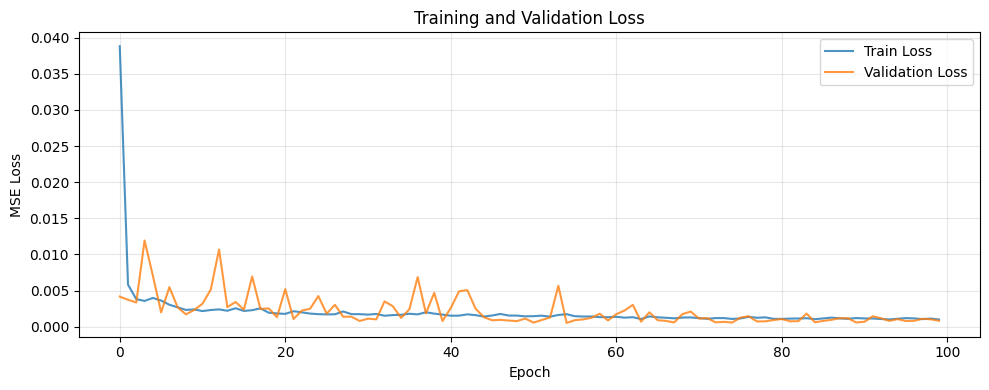

In [6]:
# Training configuration
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
n_epochs = 100
train_losses = []
val_losses = []

print("Training Simple Attention Model...")
print("=" * 50)

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_test_t)
        val_loss = criterion(val_output, y_test_t).item()
        val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

print("\n✅ Training complete!")

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Attention Weights Visualization

One of the key advantages of attention mechanisms is **interpretability**. We can see exactly which past time steps the model focuses on when making predictions.

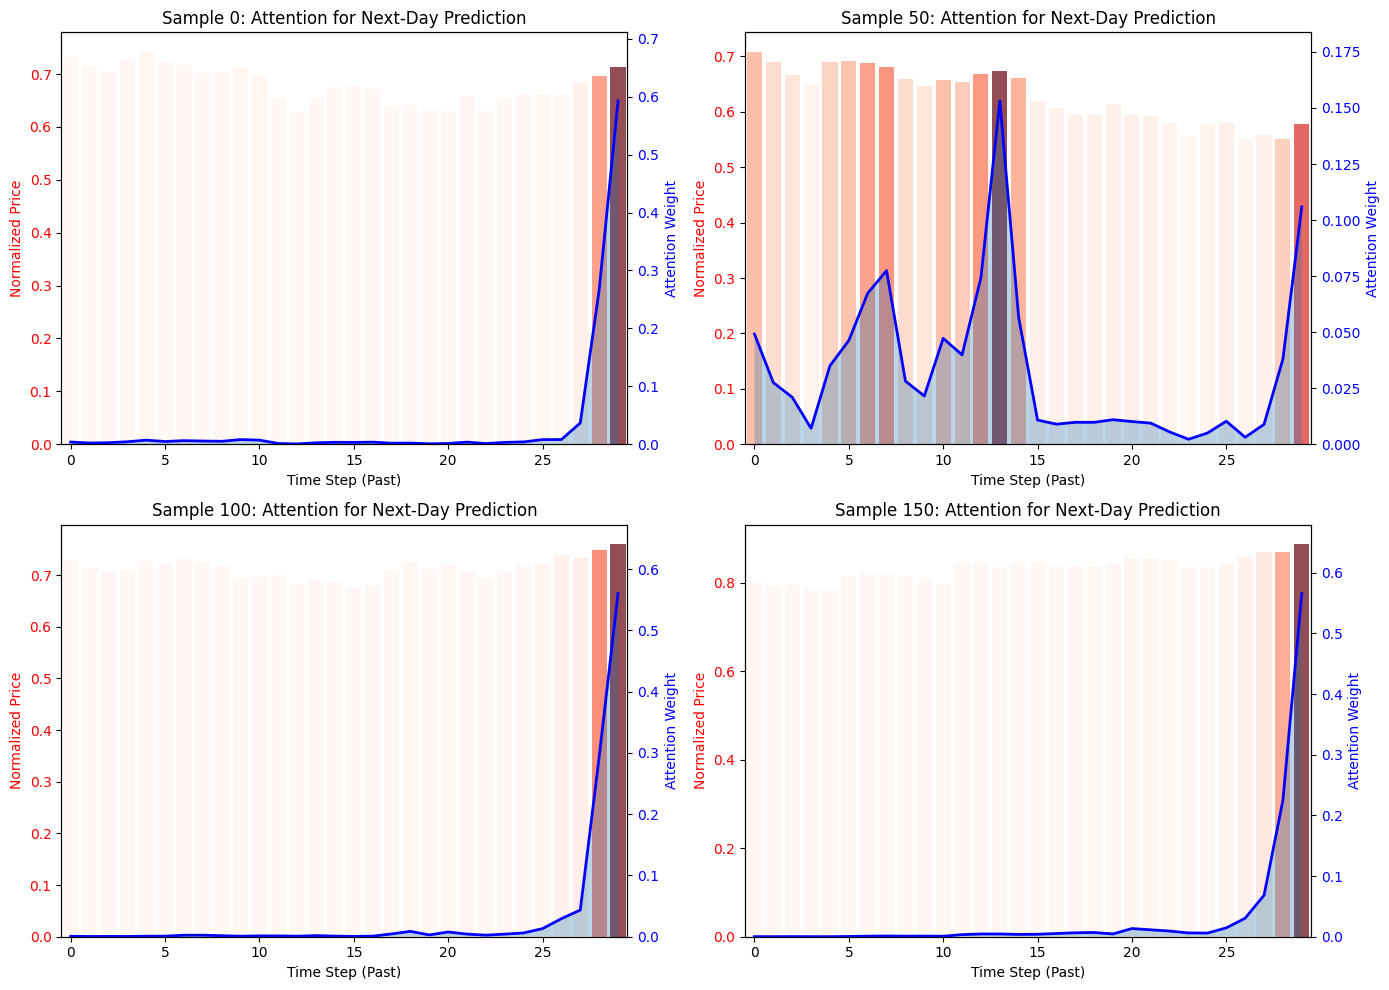


📊 Interpretation:
- Blue line shows attention weights (which past days the model focuses on)
- Red bars show normalized price values
- Higher attention = more important for prediction


In [7]:
# Get predictions and attention weights for test samples
model.eval()
with torch.no_grad():
    predictions, attention_weights = model(X_test_t, return_attention=True)

# Convert to numpy
preds_np = predictions.cpu().numpy()
attn_np = attention_weights.cpu().numpy()

# Visualize attention for specific samples
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sample indices to visualize
sample_indices = [0, 50, 100, 150]

for idx, (ax, sample_idx) in enumerate(zip(axes.flat, sample_indices)):
    if sample_idx >= len(attn_np):
        continue
    
    # Get attention weights for last query position (predicting next step)
    # Shape: (seq_len, seq_len) - we want the last row
    attn_last_position = attn_np[sample_idx, -1, :]  # What the last position attends to
    
    # Get the input sequence
    input_seq = X_test[sample_idx].flatten()
    
    # Create bar plot showing input with attention overlay
    colors = plt.cm.Reds(attn_last_position / attn_last_position.max())
    bars = ax.bar(range(SEQ_LENGTH), input_seq, color=colors, alpha=0.7)
    
    # Add attention weight annotation
    ax2 = ax.twinx()
    ax2.plot(range(SEQ_LENGTH), attn_last_position, 'b-', linewidth=2, label='Attention Weight')
    ax2.fill_between(range(SEQ_LENGTH), attn_last_position, alpha=0.3)
    ax2.set_ylabel('Attention Weight', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, attn_last_position.max() * 1.2)
    
    ax.set_xlabel('Time Step (Past)')
    ax.set_ylabel('Normalized Price', color='red')
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_title(f'Sample {sample_idx}: Attention for Next-Day Prediction')
    ax.set_xlim(-0.5, SEQ_LENGTH - 0.5)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("- Blue line shows attention weights (which past days the model focuses on)")
print("- Red bars show normalized price values")
print("- Higher attention = more important for prediction")

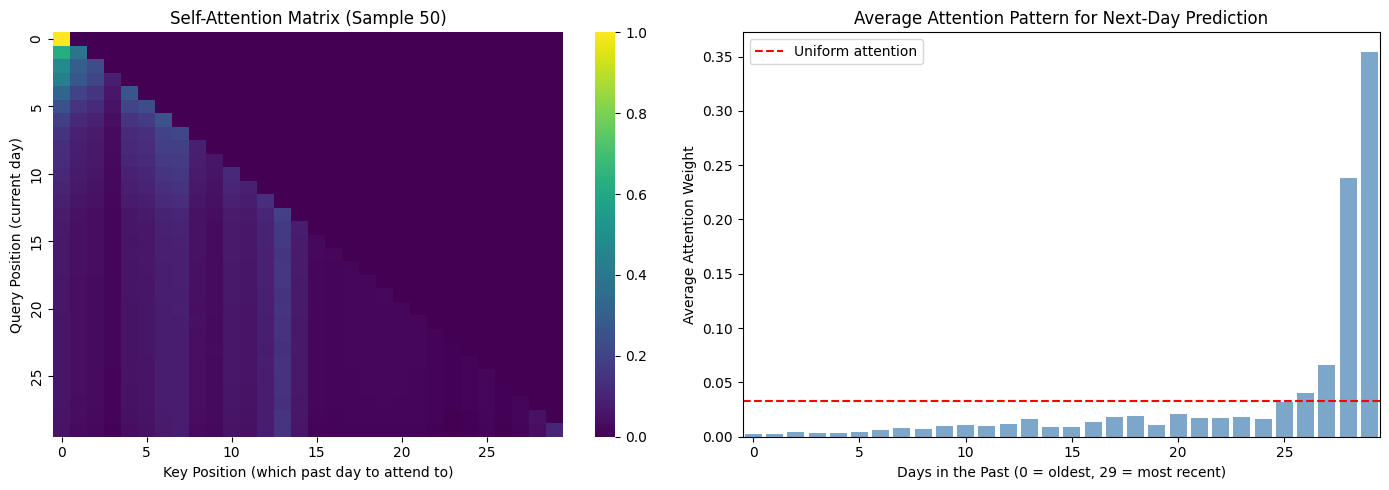


🔍 Top 5 Most Attended Positions (days ago):
  1. Position 29 (0 days ago): 0.3545
  2. Position 28 (1 days ago): 0.2383
  3. Position 27 (2 days ago): 0.0656
  4. Position 26 (3 days ago): 0.0405
  5. Position 25 (4 days ago): 0.0317


In [8]:
# Visualize full attention matrix for a single sample
sample_idx = 50

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot attention heatmap
attn_matrix = attn_np[sample_idx]
sns.heatmap(attn_matrix, cmap='viridis', ax=axes[0], 
            xticklabels=5, yticklabels=5)
axes[0].set_title(f'Self-Attention Matrix (Sample {sample_idx})', fontsize=12)
axes[0].set_xlabel('Key Position (which past day to attend to)')
axes[0].set_ylabel('Query Position (current day)')

# Plot average attention pattern
avg_attention = attn_np.mean(axis=0)  # Average across all test samples
last_row_avg = avg_attention[-1, :]  # Average attention for final prediction

axes[1].bar(range(SEQ_LENGTH), last_row_avg, color='steelblue', alpha=0.7)
axes[1].axhline(y=1/SEQ_LENGTH, color='red', linestyle='--', label='Uniform attention')
axes[1].set_xlabel('Days in the Past (0 = oldest, 29 = most recent)')
axes[1].set_ylabel('Average Attention Weight')
axes[1].set_title('Average Attention Pattern for Next-Day Prediction', fontsize=12)
axes[1].legend()
axes[1].set_xlim(-0.5, SEQ_LENGTH - 0.5)

plt.tight_layout()
plt.show()

# Find most attended positions
top_positions = np.argsort(last_row_avg)[::-1][:5]
print(f"\n🔍 Top 5 Most Attended Positions (days ago):")
for i, pos in enumerate(top_positions):
    days_ago = SEQ_LENGTH - pos - 1
    print(f"  {i+1}. Position {pos} ({days_ago} days ago): {last_row_avg[pos]:.4f}")

## 10. Model Evaluation and Predictions

Model Performance Metrics

Metric                 Train         Test
----------------------------------------
RMSE ($)                2.30         4.69
MAE ($)                 1.65         3.84
MAPE (%)                1.79         2.24


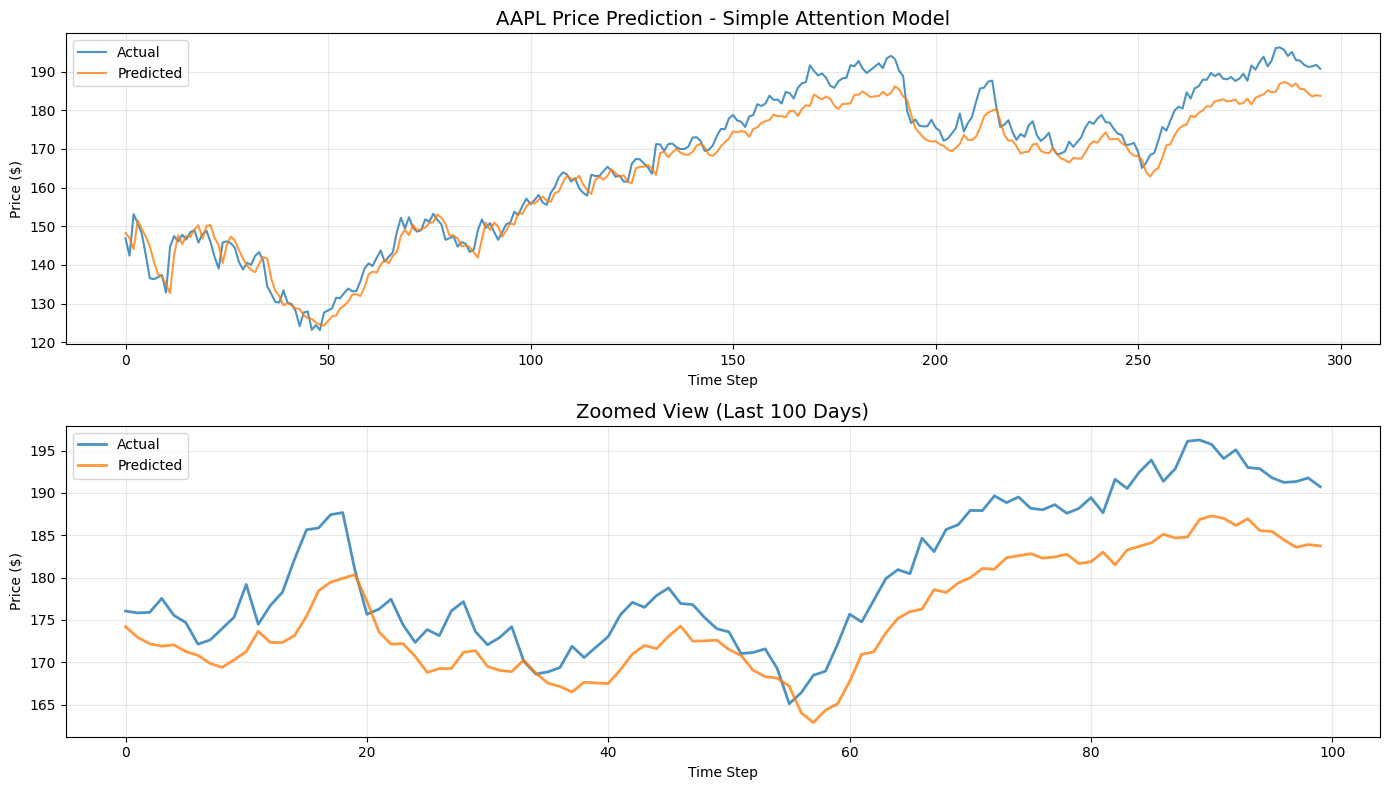

In [9]:
# Generate predictions
model.eval()
with torch.no_grad():
    train_preds = model(X_train_t).cpu().numpy()
    test_preds = model(X_test_t).cpu().numpy()

# Inverse transform
train_preds_actual = scaler.inverse_transform(train_preds)
test_preds_actual = scaler.inverse_transform(test_preds)
y_train_actual = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_preds_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_preds_actual))
train_mae = mean_absolute_error(y_train_actual, train_preds_actual)
test_mae = mean_absolute_error(y_test_actual, test_preds_actual)

# MAPE
train_mape = np.mean(np.abs((y_train_actual - train_preds_actual) / y_train_actual)) * 100
test_mape = np.mean(np.abs((y_test_actual - test_preds_actual) / y_test_actual)) * 100

print("=" * 50)
print("Model Performance Metrics")
print("=" * 50)
print(f"\n{'Metric':<15} {'Train':>12} {'Test':>12}")
print("-" * 40)
print(f"{'RMSE ($)':<15} {train_rmse:>12.2f} {test_rmse:>12.2f}")
print(f"{'MAE ($)':<15} {train_mae:>12.2f} {test_mae:>12.2f}")
print(f"{'MAPE (%)':<15} {train_mape:>12.2f} {test_mape:>12.2f}")

# Plot predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full prediction plot
axes[0].plot(y_test_actual, label='Actual', alpha=0.8)
axes[0].plot(test_preds_actual, label='Predicted', alpha=0.8)
axes[0].set_title(f'{ticker} Price Prediction - Simple Attention Model', fontsize=14)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zoomed view (last 100 points)
zoom_range = slice(-100, None)
axes[1].plot(y_test_actual[zoom_range], label='Actual', alpha=0.8, linewidth=2)
axes[1].plot(test_preds_actual[zoom_range], label='Predicted', alpha=0.8, linewidth=2)
axes[1].set_title('Zoomed View (Last 100 Days)', fontsize=14)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Key Takeaways

### What We Learned

1. **Attention Mechanism Intuition**
   - Attention computes weighted sums based on similarity (relevance)
   - Query-Key-Value framework provides flexible information retrieval
   - Self-attention captures dependencies across entire sequence

2. **Scaled Dot-Product Attention**
   - Core formula: $\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$
   - Scaling prevents softmax saturation
   - Causal masking prevents information leakage from future

3. **Interpretability**
   - Attention weights show which time steps the model focuses on
   - Useful for understanding model behavior and debugging

4. **Financial Applications**
   - Attention can capture long-range dependencies in price series
   - Pattern recognition across variable lookback periods
   - Foundation for more sophisticated Transformer models

### Next Steps (Day 2)
- Multi-head attention: Why multiple attention "perspectives" help
- Full Transformer architecture
- Positional encodings in depth

---

### Interview Questions

1. **Why do we scale by $\sqrt{d_k}$ in attention?**
   - To normalize the variance of dot products and prevent softmax saturation

2. **What's the difference between self-attention and cross-attention?**
   - Self-attention: Q, K, V from same sequence
   - Cross-attention: Q from one sequence, K, V from another

3. **Why use causal masking for time series prediction?**
   - Prevents information leakage from future time steps during training

4. **Computational complexity of self-attention?**
   - $O(n^2 \cdot d)$ - quadratic in sequence length

In [10]:
# Summary statistics
print("\n" + "=" * 60)
print("Day 1 Summary: Attention Mechanisms")
print("=" * 60)
print(f"""
✅ Concepts Covered:
   • Scaled Dot-Product Attention
   • Query, Key, Value framework
   • Causal masking for autoregressive prediction
   • Attention weight visualization

✅ Implementation:
   • Simple attention model: {total_params:,} parameters
   • Test RMSE: ${test_rmse:.2f}
   • Test MAPE: {test_mape:.2f}%

📚 Key Formula:
   Attention(Q, K, V) = softmax(QK^T / √d_k) × V

🎯 Tomorrow: Multi-Head Attention
   - Why multiple attention heads help
   - Capturing different types of relationships
""")


Day 1 Summary: Attention Mechanisms

✅ Concepts Covered:
   • Scaled Dot-Product Attention
   • Query, Key, Value framework
   • Causal masking for autoregressive prediction
   • Attention weight visualization

✅ Implementation:
   • Simple attention model: 69,985 parameters
   • Test RMSE: $4.69
   • Test MAPE: 2.24%

📚 Key Formula:
   Attention(Q, K, V) = softmax(QK^T / √d_k) × V

🎯 Tomorrow: Multi-Head Attention
   - Why multiple attention heads help
   - Capturing different types of relationships

